In [80]:
import pandas as pd
import numpy as np
import time
from tabulate import tabulate
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC, SVC
from sklearn import preprocessing
from sklearn.metrics import classification_report, f1_score
from gensim.models.word2vec import Word2Vec
from sklearn.ensemble import ExtraTreesClassifier
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
import torch
from torch.autograd import Variable
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn

In [121]:
WORK_DIR = "/home/nguyen/"
RAW_DATA = "/data/labeled_tweets.txt"
PROCESSED_DATA = "data/processed_tweets.csv"
GLOVE_6B_50D_PATH = WORK_DIR +"Glove6B/glove.6B.50d.txt"
GLOVE_840B_300D_PATH = WORK_DIR+"glove.840B.300d.txt"
ENCODING = "utf-8"
CHARACTER_VOCAB = "abcdefghijklmnopqrstuvwxyz0123456789-,;.!?:’\"/\|_#$%&^*~‘+-=<>()[]{}"


## Read data and split train, test

In [3]:
# read data and split train, test
data = pd.read_csv(WORK_DIR+PROCESSED_DATA)
# data = pd.read_csv("../examples.csv")
print("data size: {}".format(data.shape))
data.dropna(subset=['tweets'], inplace=True)
print("Data after removing NAN rows: {}".format(data.shape))


labelEncoder = preprocessing.LabelEncoder()
labels = labelEncoder.fit_transform(data.labels.values)


dataTrain, dataTest, labelTrain, labelTest = train_test_split(data.tweets.values, labels,
                                                              test_size=0.2, random_state=42, stratify=labels)

data size: (302925, 2)
Data after removing NAN rows: (302453, 2)


In [4]:
print(data.groupby('labels').count())

                         tweets
labels                         
Business                  35539
Education                 12925
Entertainment             22484
Health                    28798
Law and Crime             16105
Politics                  45089
Religion                  11310
Science and Technology    32256
Sports                    43503
Travel                    38394
Weather and Environment   16050


## Load pretrained glove embedding

In [5]:
# read glove vectors
glove_small = {}

all_words = set(w for words in dataTrain for w in words)
with open(GLOVE_6B_50D_PATH, "rb") as infile:
    for line in infile:
        parts = line.split()
        word = parts[0].decode(ENCODING)
        if (word in all_words):
            nums=np.array(parts[1:], dtype=np.float32)
            glove_small[word] = nums

            
glove_big = {}
with open(GLOVE_840B_300D_PATH, "rb") as infile:
    for line in infile:
        parts = line.split()
        word = parts[0].decode(ENCODING)
        if word in all_words:
            nums=np.array(parts[1:], dtype=np.float32)
            glove_big[word] = nums

## Learn word embedding from scratch using only train dataset

In [6]:
# word2vec embendding trained from scratch
model = Word2Vec(dataTrain, size=100, window=5, min_count=5, workers=2)
w2v = {w: vec for w, vec in zip(model.wv.index2word, list(model.wv.vectors))}

## Different ways to form tweet vector by combining word embeddings

In [25]:
class MeanEmbeddingVectorizer(object):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        self.dim=len(word2vec[next(iter(word2vec))])
            
    def fit(self, X):
        return self 

    def transform(self, X):
        return np.array([
            np.mean([self.word2vec[w] for w in words if w in self.word2vec] 
                    or [np.zeros(self.dim)], axis=0)
            for words in X
        ])

    
# and a tf-idf version of the same
##> each input is represented as a mean of embedding*tfidf if individual words
class TfidfEmbeddingVectorizer(object):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        self.word2weight = None
        self.dim=len(word2vec[next(iter(word2vec))])
       
        
    def fit(self, X):
        tfidf = TfidfVectorizer(analyzer=lambda x: x)
        tfidf.fit(X)

        max_idf = max(tfidf.idf_)
        self.word2weight = defaultdict(
            lambda: max_idf, 
            [(w, tfidf.idf_[i]) for w, i in tfidf.vocabulary_.items()])
    
        return self
    
    def transform(self, X):
        return np.array([
                np.mean([self.word2vec[w] * self.word2weight[w]
                         for w in words if w in self.word2vec] or
                        [np.zeros(self.dim)], axis=0)
                for words in X
            ])

## Run different models

In [31]:
def run_model(name, model, vectorizer):
    vectorizer.fit(dataTrain)
    features_train = vectorizer.transform(dataTrain)
    features_test = vectorizer.transform(dataTest)
    print("Training features: {}".format(features_train.shape))
    # print(vectorizer.get_feature_names())
    print("Training......................")
    
    model.fit(features_train, labelTrain)
    print("Predicting....................")
    predTest = model.predict(features_test)
    f1_test = f1_score(predTest, labelTest, average = 'micro')
    f1_train = f1_score(model.predict(features_train), labelTrain, average = 'micro')
    print("Model: {} F1 Train: {}\n".format(name, f1_train))
    print("Model: {} F1 Test: {}\n".format(name, f1_test))
    print(classification_report(predTest, labelTest))
#     f1_scores.append(f1)
    return f1_train, f1_test

In [32]:
# svc tfidf
f1_scores_train = []
f1_scores_test = []
model_name = "svc_tfidf"
vectorizer = TfidfVectorizer()
svc_tfidf = LinearSVC(multi_class='ovr', C = 0.01, random_state=42)
f1_train, f1_test = run_model(model_name, svc_tfidf, vectorizer)
f1_scores_train.append([model_name, f1_train])
f1_scores_test.append([model_name, f1_test])

Training features: (241962, 101030)
Training......................
Predicting....................
Model: svc_tfidf F1 Train: 0.7757705755449202

Model: svc_tfidf F1 Test: 0.7576168355623151

              precision    recall  f1-score   support

           0       0.55      0.66      0.60      5934
           1       0.68      0.79      0.73      2219
           2       0.68      0.80      0.73      3796
           3       0.78      0.72      0.75      6248
           4       0.61      0.83      0.70      2362
           5       0.87      0.77      0.82     10195
           6       0.58      0.92      0.71      1424
           7       0.61      0.68      0.64      5748
           8       0.94      0.79      0.86     10266
           9       0.89      0.73      0.80      9328
          10       0.82      0.88      0.85      2971

    accuracy                           0.76     60491
   macro avg       0.73      0.78      0.74     60491
weighted avg       0.78      0.76      0.76     604

In [37]:
# mean word2vec
print("Vectorizer......................")
model_name = 'w2v_meanEmbedding'
vectorizer = MeanEmbeddingVectorizer(w2v)
model = ExtraTreesClassifier(n_estimators=100, random_state=42)
f1_train, f1_test = run_model(model_name, model, vectorizer)

Vectorizer......................
Training features: (241962, 100)
Training......................
Predicting....................
Model: w2v_meanEmbedding F1 Train: 0.9904075846620544

Model: w2v_meanEmbedding F1 Test: 0.41754971813988856

              precision    recall  f1-score   support

           0       0.32      0.45      0.37      5006
           1       0.35      0.82      0.49      1108
           2       0.26      0.72      0.38      1641
           3       0.37      0.61      0.46      3475
           4       0.31      0.64      0.42      1559
           5       0.65      0.36      0.46     16492
           6       0.24      0.94      0.38       580
           7       0.27      0.41      0.32      4199
           8       0.61      0.33      0.42     16095
           9       0.46      0.41      0.43      8666
          10       0.26      0.51      0.35      1670

    accuracy                           0.42     60491
   macro avg       0.37      0.56      0.41     60491
weig

In [41]:
f1_scores_train.append([model_name, f1_train])
f1_scores_test.append([model_name, f1_test])

In [42]:
f1_scores_train

[['svc_tfidf', 0.7757705755449202], ['w2v_meanEmbedding', 0.9904075846620544]]

In [48]:
# tfidf weighted word2vec
model_name = "w2v_tfidfEmbedding"
vectorizer = TfidfEmbeddingVectorizer(w2v)
model = ExtraTreesClassifier(n_estimators=200, random_state=42)
f1_train, f1_test = run_model(model_name, model, vectorizer)

Training features: (241962, 100)
Training......................
Predicting....................
Model: w2v_tfidfEmbedding F1 Train: 0.9904075846620544

Model: w2v_tfidfEmbedding F1 Test: 0.4247739333123936

              precision    recall  f1-score   support

           0       0.31      0.51      0.38      4297
           1       0.35      0.85      0.49      1051
           2       0.26      0.83      0.40      1425
           3       0.36      0.65      0.46      3231
           4       0.29      0.71      0.42      1333
           5       0.67      0.36      0.47     16834
           6       0.24      0.96      0.38       555
           7       0.27      0.44      0.33      3856
           8       0.63      0.33      0.43     16714
           9       0.49      0.40      0.44      9352
          10       0.29      0.50      0.37      1843

    accuracy                           0.42     60491
   macro avg       0.38      0.59      0.42     60491
weighted avg       0.52      0.42   

In [49]:
f1_scores_train.append([model_name, f1_train])
f1_scores_test.append([model_name, f1_test])

In [51]:
# pretrained glove_small embedding
model_name = "global_small"
vectorizer = MeanEmbeddingVectorizer(glove_small)
model = ExtraTreesClassifier(n_estimators=200, random_state=42)
f1_train, f1_test = run_model(model_name, model, vectorizer)

Training features: (241962, 50)
Training......................
Predicting....................
Model: global_small F1 Train: 0.9903951860209455

Model: global_small F1 Test: 0.4055809955199947

              precision    recall  f1-score   support

           0       0.31      0.50      0.38      4384
           1       0.32      0.91      0.48       910
           2       0.26      0.77      0.38      1496
           3       0.35      0.67      0.46      2993
           4       0.22      0.74      0.34       953
           5       0.65      0.34      0.44     17539
           6       0.24      0.96      0.38       558
           7       0.25      0.44      0.32      3713
           8       0.60      0.30      0.40     17378
           9       0.48      0.39      0.43      9426
          10       0.20      0.57      0.30      1141

    accuracy                           0.41     60491
   macro avg       0.35      0.60      0.39     60491
weighted avg       0.51      0.41      0.41     6

In [52]:
f1_scores_train.append([model_name, f1_train])
f1_scores_test.append([model_name, f1_test])

In [53]:
# pretrained glove_small weighted embedding
model_name = "glove_small_tfidf"
vectorizer = TfidfEmbeddingVectorizer(glove_small)
model = ExtraTreesClassifier(n_estimators=200, random_state=42)
f1 = run_model(model_name, model, vectorizer)

Training features: (241962, 50)
Training......................
Predicting....................
Model: glove_small_tfidf F1 Train: 0.9904034517816848

Model: glove_small_tfidf F1 Test: 0.4148385710270949

              precision    recall  f1-score   support

           0       0.30      0.51      0.38      4256
           1       0.32      0.93      0.48       899
           2       0.26      0.78      0.39      1523
           3       0.35      0.68      0.47      2992
           4       0.22      0.78      0.35       914
           5       0.67      0.34      0.46     17564
           6       0.23      0.96      0.38       552
           7       0.25      0.45      0.33      3635
           8       0.62      0.31      0.41     17249
           9       0.49      0.40      0.44      9603
          10       0.24      0.59      0.34      1304

    accuracy                           0.41     60491
   macro avg       0.36      0.61      0.40     60491
weighted avg       0.53      0.41      

In [54]:
f1_scores_train.append([model_name, f1_train])
f1_scores_test.append([model_name, f1_test])

In [55]:
model_name = "glove_big"
vectorizer = MeanEmbeddingVectorizer(glove_big)
model = ExtraTreesClassifier(n_estimators=200, random_state=42)
f1_train, f1_test = run_model(model_name, model, vectorizer)

Training features: (241962, 300)
Training......................
Predicting....................
Model: glove_big F1 Train: 0.9904034517816848

Model: glove_big F1 Test: 0.4283116496668926

              precision    recall  f1-score   support

           0       0.31      0.51      0.39      4319
           1       0.36      0.86      0.50      1078
           2       0.27      0.77      0.40      1543
           3       0.37      0.63      0.47      3374
           4       0.26      0.76      0.39      1117
           5       0.68      0.36      0.47     16919
           6       0.24      0.96      0.38       559
           7       0.27      0.45      0.33      3822
           8       0.62      0.32      0.43     16716
           9       0.51      0.41      0.46      9435
          10       0.28      0.56      0.37      1609

    accuracy                           0.43     60491
   macro avg       0.38      0.60      0.42     60491
weighted avg       0.53      0.43      0.44     60491


In [56]:
f1_scores_train.append([model_name, f1_train])
f1_scores_test.append([model_name, f1_test])

In [57]:
model_name = "glove_big_tfidf"
vectorizer = TfidfEmbeddingVectorizer(glove_big)
model = ExtraTreesClassifier(n_estimators=200, random_state=42)
f1 = run_model(model_name, model, vectorizer)

Training features: (241962, 300)
Training......................
Predicting....................
Model: glove_big_tfidf F1 Train: 0.9904034517816848

Model: glove_big_tfidf F1 Test: 0.4339488518953233

              precision    recall  f1-score   support

           0       0.31      0.51      0.39      4341
           1       0.35      0.86      0.49      1044
           2       0.27      0.82      0.41      1501
           3       0.37      0.65      0.47      3327
           4       0.26      0.79      0.39      1075
           5       0.68      0.37      0.48     16675
           6       0.24      0.97      0.38       557
           7       0.27      0.45      0.34      3873
           8       0.64      0.33      0.44     16729
           9       0.52      0.42      0.46      9510
          10       0.30      0.53      0.39      1859

    accuracy                           0.43     60491
   macro avg       0.38      0.61      0.42     60491
weighted avg       0.53      0.43      0.4

In [59]:
f1_scores_train.append([model_name, f1_train])
f1_scores_test.append([model_name, f1_test])

               models  F1_train   F1_test
0           svc_tfidf  0.775771  0.757617
1   w2v_meanEmbedding  0.990408  0.417550
2  w2v_tfidfEmbedding  0.990408  0.424774
3        global_small  0.990395  0.405581
4   glove_small_tfidf  0.990395  0.405581
5           glove_big  0.990403  0.428312
6     glove_big_tfidf  0.990403  0.428312
7     glove_big_tfidf  0.990403  0.428312
8     glove_big_tfidf  0.990403  0.428312
9     glove_big_tfidf  0.990403  0.428312


(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), <a list of 10 Text xticklabel objects>)

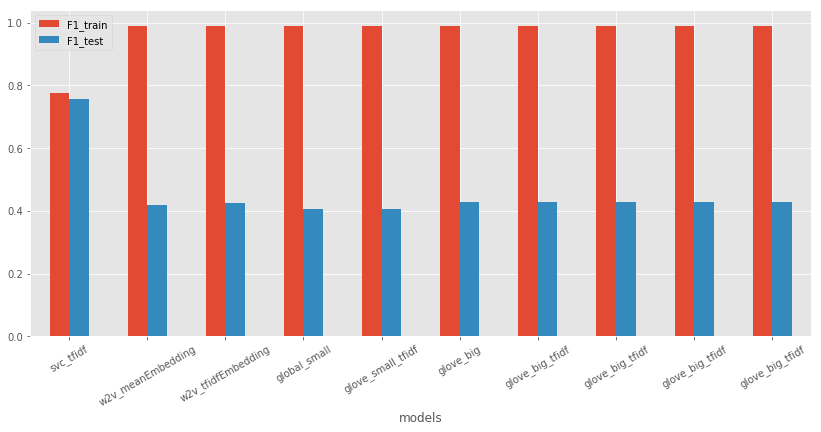

In [75]:
#plot
plottedData = pd.DataFrame(f1_scores_train, columns = ['models', 'F1_train'])
plottedData = plottedData.merge(pd.DataFrame(f1_scores_test, columns =['models', 'F1_test']), how = 'left', on='models')
print(plottedData)
plt.style.use('ggplot')
plt.rcParams["figure.figsize"] = (14,6)
plottedData.plot(x = 'models', y = ['F1_train', 'F1_test'], kind = 'bar')
plt.xticks(rotation = '30')

## Train on a simpler model: Reduce number of estimators
- Result on test set gets reduced

In [61]:
# reduce the number of estimators
model_name = "glove_big_tfidf"
vectorizer = TfidfEmbeddingVectorizer(glove_big)
model = ExtraTreesClassifier(n_estimators=15, random_state=42)
f1 = run_model(model_name, model, vectorizer)

Training features: (241962, 300)
Training......................
Predicting....................
Model: glove_big_tfidf F1 Train: 0.9904034517816848

Model: glove_big_tfidf F1 Test: 0.3696417648906449

              precision    recall  f1-score   support

           0       0.38      0.30      0.33      8943
           1       0.36      0.58      0.45      1630
           2       0.31      0.36      0.33      3854
           3       0.39      0.41      0.40      5397
           4       0.26      0.40      0.32      2096
           5       0.53      0.36      0.43     13104
           6       0.25      0.60      0.35       921
           7       0.27      0.33      0.30      5317
           8       0.41      0.33      0.36     10795
           9       0.38      0.43      0.41      6791
          10       0.22      0.43      0.29      1643

    accuracy                           0.37     60491
   macro avg       0.34      0.41      0.36     60491
weighted avg       0.39      0.37      0.3

## word2vec embedding trained from scratch on the whole dataset

In [77]:
model = Word2Vec(data.tweets.values, size=100, window=5, min_count=5, workers=2)
w2v = {w: vec for w, vec in zip(model.wv.index2word, list(model.wv.vectors))}

model_name = "w2v_allData"
vectorizer = MeanEmbeddingVectorizer(w2v)
model = ExtraTreesClassifier(n_estimators=200, random_state=42)
f1_train, f1_test = run_model(model_name, model, vectorizer)


Training features: (241962, 100)
Training......................
Predicting....................
Model: w2v_allData F1 Train: 0.9904075846620544

Model: w2v_allData F1 Test: 0.42715445272850505

              precision    recall  f1-score   support

           0       0.31      0.51      0.38      4301
           1       0.34      0.87      0.49      1008
           2       0.26      0.81      0.39      1437
           3       0.36      0.67      0.47      3129
           4       0.29      0.72      0.42      1318
           5       0.66      0.35      0.46     16921
           6       0.23      0.96      0.38       548
           7       0.28      0.43      0.34      4149
           8       0.65      0.33      0.44     16975
           9       0.49      0.41      0.45      9169
          10       0.27      0.56      0.36      1536

    accuracy                           0.43     60491
   macro avg       0.38      0.60      0.42     60491
weighted avg       0.53      0.43      0.43     6

## Character level tweet embedding

In [1]:
import pandas as pd
import numpy as np
import time
from tabulate import tabulate
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC, SVC
from sklearn import preprocessing
from sklearn.metrics import classification_report, f1_score
from gensim.models.word2vec import Word2Vec
from sklearn.ensemble import ExtraTreesClassifier
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
import torch
from torch.autograd import Variable
from torch.utils.data import DataLoader, Dataset, TensorDataset
import torch.nn as nn

In [2]:
WORK_DIR = "/home/nguyen/"
RAW_DATA = "/data/labeled_tweets.txt"
PROCESSED_DATA = "data/processed_tweets.csv"
GLOVE_6B_50D_PATH = WORK_DIR +"Glove6B/glove.6B.50d.txt"
GLOVE_840B_300D_PATH = WORK_DIR+"glove.840B.300d.txt"
ENCODING = "utf-8"
CHARACTER_VOCAB = "abcdefghijklmnopqrstuvwxyz0123456789-,;.!?:’\"/\|_#$%&^*~‘+-=<>()[]{}"

In [3]:
# hyperparameter settings
max_len = 140
vocab_size = 75
batch_size = 64
learning_rate = 0.01
hidden_size = 50
num_epochs = 5

In [4]:
# read data and split train, test
data = pd.read_csv(WORK_DIR+PROCESSED_DATA)
# data = pd.read_csv("../examples.csv")
print("data size: {}".format(data.shape))
data.dropna(subset=['tweets'], inplace=True)
print("Data after removing NAN rows: {}".format(data.shape))


labelEncoder = preprocessing.LabelEncoder()
labels = labelEncoder.fit_transform(data.labels.values)


dataTrain, dataTest, labelTrain, labelTest = train_test_split(data.tweets.values, labels,
                                                              test_size=0.2, random_state=42, stratify=labels)

data size: (302925, 2)
Data after removing NAN rows: (302453, 2)


In [5]:
# # convert data to index vectors
# int2char = dict(enumerate(CHARACTER_VOCAB))
# char2int = {char: index+1 for index, char in int2char.items()}


# def charToIndex(data, max_len):
#     encoded = np.zeros((data.shape[0], max_len), dtype=np.int64)
    
#     lineCount = 0
#     for line in data:
#         charCount=0
#         for index_char, char in enumerate(line[::-1]):
#             charCount+=1
    
            
#             if charCount> max_len:
#                 break
#             if char in char2int:
#                 encoded[lineCount][index_char] = char2int[char]
#         lineCount +=1
#     return encoded

In [6]:
# create one-hot vector
# def oneHotVector(data, vocab_size):
   
#     one_hot = torch.zeros((np.multiply(*data.shape), vocab_size), dtype=torch.int32)
#     # Fill the appropriate elements with ones
#     one_hot[np.arange(one_hot.shape[0]), data.flatten()] = 1.
    
#     # Finally reshape it to get back to the original array
#     one_hot = one_hot.reshape((*data.shape, vocab_size))
    
#     return one_hot

In [7]:
# #test
# x = np.array(['fdfd', 'sfe'])
# encoded = charToIndex(x, 14)
# print(encoded)
# test_seq = np.array([[3, 5, 1], [4,3,2]])
# print(test_seq)
# one_hot = oneHotVector(encoded, 20)

# print(one_hot)

In [8]:
# #
# x_train = charToIndex(dataTrain, max_len)
# x_test = charToIndex(dataTest, max_len)
# y_train = torch.LongTensor(labelTrain)
# y_test = torch.LongTensor(labelTest)

In [9]:
set(labelTrain)

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10}

In [10]:
class DataReader(Dataset):
    def __init__(self, data, labels, alphabet, max_len):
        self.max_len = max_len
        self.y = torch.LongTensor(labels)
        self.data = data
        self.label = labels
        self.alphabet = alphabet
            
    def __len__(self):
        return len(self.label)


    def __getitem__(self, idx):
        X = self.index(idx)
        y = self.y[idx]
        return X, y

    def index(self, idx):
        X = torch.zeros(self.max_len, dtype = torch.long)
        sequence = self.data[idx]
        i=0
        for index_char, char in enumerate(sequence[::-1]):
            i+=1
            if i> self.max_len:
                break
            if self.char2Index(char)!=-1:
                X[index_char] = self.char2Index(char)
        return X
    
    
    def oneHotEncode(self, idx):
        # X = (batch, 70, sequence_length)
        X = torch.zeros(len(self.alphabet), self.max_len)
       
        sequence = self.data[idx]
        
        i=0
        for index_char, char in enumerate(sequence[::-1]):
            i+=1
            if i> self.max_len:
                break
            if self.char2Index(char)!=-1:
                X[self.char2Index(char)][index_char] = 1.0
        return X

    def char2Index(self, character):
        return self.alphabet.find(character)


In [11]:
train_dataset = DataReader(dataTrain, labelTrain, CHARACTER_VOCAB, max_len)
train_loader = DataLoader(train_dataset, batch_size=64, num_workers=4, drop_last=False)

test_dataset = DataReader(dataTest, labelTest, CHARACTER_VOCAB, max_len)
test_loader = DataLoader(test_dataset, batch_size=64*2, num_workers=4, drop_last=False)

# for i_batch, sample_batched in enumerate(train_loader):
#     if i_batch == 0:
#         print(sample_batched[0])

In [28]:
class BiGRUModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(BiGRUModel, self).__init__()
        self.hidden_size = hidden_size
        
        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, bidirectional = False)
        
        
        self.out = nn.Linear(hidden_size, output_size)
    
    def forward(self, input, hidden):
#         print(input.shape)
        batch_size = input.size(0)
        embedded = self.embedding(input).view(input.size(1),batch_size,-1)
#         print(embedded.shape)
        output, hidden = self.gru(embedded, hidden)
#         print(output.shape)
        
        output = self.out(output).view(batch_size, -1)
#         print(output.shape)
        return output, hidden
    def initHidden(self, batch_size):
        return torch.zeros(1, batch_size, self.hidden_size)
      

### layers' size:
- input size:  
    + torch.Size([64, 140]): batch_size, max_len
- embedding size:
    + torch.Size([140, 64, 50]): max_len, batch_size, embedding_size
- GRU size:
    + torch.Size([140, 64, 50]): max_len, batch_size, embedding_size
- Linear size: 
    + torch.Size([64, 1540]): batch_size, flatten_GRU
- Softmax:
    + torch.Size([64, 1]): batch_size, output

In [29]:
model = BiGRUModel(vocab_size, hidden_size, len(set(labelTrain)))
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)
loss_func = nn.CrossEntropyLoss()

In [39]:
print("Train size: ", dataTrain.shape)
print("Batch: ", batch_size)
print("#Number of iter per each epoch: ", (dataTrain.shape[0]/batch_size))

print("Test size: ", dataTest.shape)
print("#iters per epoch: ", (dataTest.shape[0]/(3*batch_size)))

Train size:  (241962,)
Batch:  64
#Number of iter per each epoch:  3780.65625
Test size:  (60491,)
#iters per epoch:  315.0572916666667


In [45]:
device = torch.device('cuda:0')
model.to(device)

BiGRUModel(
  (embedding): Embedding(75, 50)
  (gru): GRU(50, 50)
  (out): Linear(in_features=50, out_features=11, bias=True)
)

In [43]:
count = 0
loss_list = []
f1_list = []
iteration_list = []
for epoch in range(num_epochs):
    running_loss = 0.0
    model.train()
    for i, batch in enumerate(train_loader):
        train, labels = batch
       
        optimizer.zero_grad()
        hidden = model.initHidden(train.size(0))
        
        
        outputs, _ = model(train, hidden)
        
        loss = loss_func(outputs, labels)        
        loss.backward()
        
        optimizer.step()
        running_loss += loss.item()
        if i % 50 == 49:    # print every 2000 mini-batches
            print('--(Epoch, iter): [%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 50))
            running_loss = 0.0
            

    model.eval()
    test_loss = 0
    f1 = 0
    with torch.no_grad():
        for i, batch in enumerate(test_loader):
            test, labels = batch
            hidden = model.initHidden(test.size(0))
            pred, _  = model(test, hidden)
            test_loss += loss_func(pred, labels)
            
            _, pred = torch.max(pred.data, 1)
#             print(pred.shape)
#             print(labels.shape)
            
            f1 += f1_score(pred, labels, average = 'micro')
            
    print("Epoch: ", epoch, "--- Loss: ", test_loss / len(test_loader), '---F1: ', (f1/len(test_loader)))
        
#         if count %50 == 0:
            
#             correct = 0
#             total = 0
#             predicted=[]
#             for i, batch in enumerate(test_loader):
#                 test, labels = batch
#                 test = test.view(batch_size, 1, max_len, vocab_size)
                 
#                 outputs = model(test)
                
#                 predicted.append(torch.max(outputs.data, 1)[1])
                
#             f1 = f1_score(predicted, labelTest)
            
#             loss_list.append(loss.data)
#             iteration_list.append(count)
#             if count% 100 == 0:
#                 print('Iteration: {}, Loss: {}, F1: {}%'.format(count, loss.data, f1))        

--(Epoch, iter): [1,    50] loss: 6.448
--(Epoch, iter): [1,   100] loss: 6.376
--(Epoch, iter): [1,   150] loss: 6.342
--(Epoch, iter): [1,   200] loss: 6.287
--(Epoch, iter): [1,   250] loss: 6.280
--(Epoch, iter): [1,   300] loss: 6.287
--(Epoch, iter): [1,   350] loss: 6.231
--(Epoch, iter): [1,   400] loss: 6.211
--(Epoch, iter): [1,   450] loss: 6.223
--(Epoch, iter): [1,   500] loss: 6.198
--(Epoch, iter): [1,   550] loss: 6.192
--(Epoch, iter): [1,   600] loss: 6.155
--(Epoch, iter): [1,   650] loss: 6.176
--(Epoch, iter): [1,   700] loss: 6.143
--(Epoch, iter): [1,   750] loss: 6.195
--(Epoch, iter): [1,   800] loss: 6.147
--(Epoch, iter): [1,   850] loss: 6.173
--(Epoch, iter): [1,   900] loss: 6.164
--(Epoch, iter): [1,   950] loss: 6.139
--(Epoch, iter): [1,  1000] loss: 6.154
--(Epoch, iter): [1,  1050] loss: 6.139
--(Epoch, iter): [1,  1100] loss: 6.117
--(Epoch, iter): [1,  1150] loss: 6.104
--(Epoch, iter): [1,  1200] loss: 6.165
--(Epoch, iter): [1,  1250] loss: 6.106


--(Epoch, iter): [3,  2650] loss: 6.052
--(Epoch, iter): [3,  2700] loss: 6.032
--(Epoch, iter): [3,  2750] loss: 6.029
--(Epoch, iter): [3,  2800] loss: 6.045
--(Epoch, iter): [3,  2850] loss: 5.972
--(Epoch, iter): [3,  2900] loss: 5.955
--(Epoch, iter): [3,  2950] loss: 5.935
--(Epoch, iter): [3,  3000] loss: 5.926
--(Epoch, iter): [3,  3050] loss: 5.885
--(Epoch, iter): [3,  3100] loss: 5.835
--(Epoch, iter): [3,  3150] loss: 5.727
--(Epoch, iter): [3,  3200] loss: 5.726
--(Epoch, iter): [3,  3250] loss: 5.713
--(Epoch, iter): [3,  3300] loss: 5.684
--(Epoch, iter): [3,  3350] loss: 5.663
--(Epoch, iter): [3,  3400] loss: 5.618
--(Epoch, iter): [3,  3450] loss: 5.582
--(Epoch, iter): [3,  3500] loss: 5.556
--(Epoch, iter): [3,  3550] loss: 5.533
--(Epoch, iter): [3,  3600] loss: 5.584
--(Epoch, iter): [3,  3650] loss: 5.523
--(Epoch, iter): [3,  3700] loss: 5.454
--(Epoch, iter): [3,  3750] loss: 5.497
Epoch:  2 --- Loss:  tensor(6.2205) ---F1:  0.015641516913319237
--(Epoch, iter)

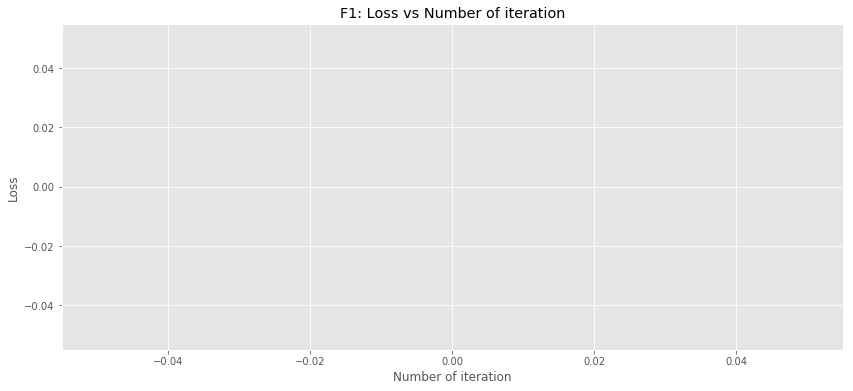

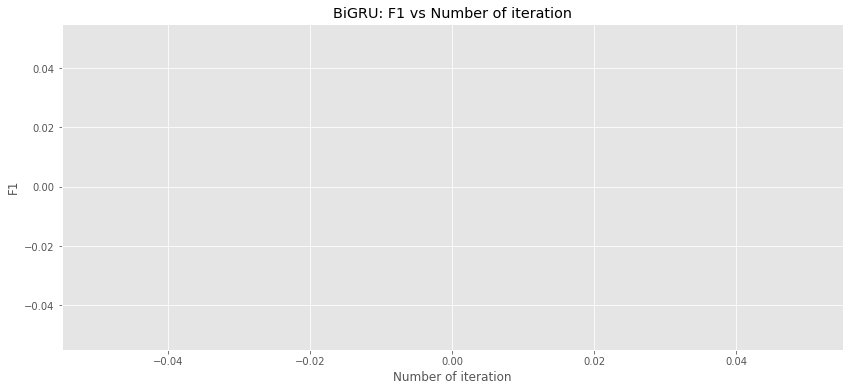

In [135]:
plt.plot(iteration_list,loss_list)
plt.xlabel("Number of iteration")
plt.ylabel("Loss")
plt.title("F1: Loss vs Number of iteration")
plt.show()

# visualization F1 
plt.plot(iteration_list,f1_list,color = "red")
plt.xlabel("Number of iteration")
plt.ylabel("F1")
plt.title("BiGRU: F1 vs Number of iteration")
plt.show()

In [182]:
x = data.copy(deep = True)

In [186]:
x['len'] = x['tweets'].apply(lambda x: len(x))

In [187]:
x.head(n=5)

,tweets,labels,len
0,breaking federal judge dismisses president tru...,Politics,84
1,joe biden grapples attacks president trump ris...,Politics,63
2,read letter former national security officials...,Politics,89
3,rt newday jaw floor says sen chriscoons sen ro...,Politics,95
4,pete buttigieg proposes seizing patents enforc...,Politics,113


In [189]:
x['len'].max()

294

In [204]:
s = x[x['len'] == x['len'].max()]['tweets'].values

In [ ]:
x_train, x_test= map(torch.tensor, (x_train, x_test))

In [12]:
train_loader = TensorDataset(x_train, y_train)
test_loader = TensorDataset(x_test, y_test)
train_loader = DataLoader(train_loader, batch_size = batch_size, shuffle = True)
test_loader = DataLoader(test_loader, batch_size = batch_size * 2, shuffle = True)

NameError: name 'x_train' is not defined